# Segmentation

In this homework you are going to implement and train a UNet model for image segmentation 

In [ ]:
import os
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets.utils import download_url
from PIL import Image
import matplotlib.pyplot as plt

## Data

We are going to use camvid dataset for image segmentation

In [ ]:
!wget --quiet --show-progress https://www.dropbox.com/s/5pylcjrrrtybbmo/camvid.tar?dl=0 -O camvid.tar
!tar -xf camvid.tar

camvid.tar          100%[===================>] 179.24M  30.6MB/s    in 6.4s    


In [ ]:
def get_files(folder, name_filter=None, extension_filter=None):
    if not os.path.isdir(folder):
        raise RuntimeError("\"{0}\" is not a folder.".format(folder))

    if name_filter is None:
        name_cond = lambda filename: True
    else:
        name_cond = lambda filename: name_filter in filename

    if extension_filter is None:
        ext_cond = lambda filename: True
    else:
        ext_cond = lambda filename: filename.endswith(extension_filter)

    filtered_files = []

    for path, _, files in os.walk(folder):
        files.sort()
        for file in files:
            if name_cond(file) and ext_cond(file):
                full_path = os.path.join(path, file)
                filtered_files.append(full_path)

    return filtered_files


def pil_loader(data_path, label_path):
    data = Image.open(data_path)
    label = Image.open(label_path)
    return data, label


class CamVid(torch.utils.data.Dataset):
    train_folder = 'train'
    train_lbl_folder = 'trainannot'

    val_folder = 'val'
    val_lbl_folder = 'valannot'

    test_folder = 'test'
    test_lbl_folder = 'testannot'

    img_extension = '.png'

    color_encoding = OrderedDict([
        ('sky', (128, 128, 128)),
        ('building', (128, 0, 0)),
        ('pole', (192, 192, 128)),
        ('road_marking', (255, 69, 0)),
        ('road', (128, 64, 128)),
        ('pavement', (60, 40, 222)),
        ('tree', (128, 128, 0)),
        ('sign_symbol', (192, 128, 128)),
        ('fence', (64, 64, 128)),
        ('car', (64, 0, 128)),
        ('pedestrian', (64, 64, 0)),
        ('bicyclist', (0, 128, 192)),
        ('unlabeled', (0, 0, 0))
    ])

    def __init__(self,
                 root_dir,
                 mode='train',
                 transform=None,
                 label_transform=None,
                 loader=pil_loader):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.label_transform = label_transform
        self.loader = loader

        if self.mode.lower() == 'train':
            # Get the training data and labels filepaths
            self.train_data = get_files(
                os.path.join(root_dir, self.train_folder),
                extension_filter=self.img_extension)

            self.train_labels = get_files(
                os.path.join(root_dir, self.train_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'val':
            # Get the validation data and labels filepaths
            self.val_data = get_files(
                os.path.join(root_dir, self.val_folder),
                extension_filter=self.img_extension)

            self.val_labels = get_files(
                os.path.join(root_dir, self.val_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'test':
            # Get the test data and labels filepaths
            self.test_data = get_files(
                os.path.join(root_dir, self.test_folder),
                extension_filter=self.img_extension)

            self.test_labels = get_files(
                os.path.join(root_dir, self.test_lbl_folder),
                extension_filter=self.img_extension)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

    def __getitem__(self, index):
        """
        Args:
        - index (``int``): index of the item in the dataset
        Returns:
        A tuple of ``PIL.Image`` (image, label) where label is the ground-truth
        of the image.
        """
        if self.mode.lower() == 'train':
            data_path, label_path = self.train_data[index], self.train_labels[
                index]
        elif self.mode.lower() == 'val':
            data_path, label_path = self.val_data[index], self.val_labels[
                index]
        elif self.mode.lower() == 'test':
            data_path, label_path = self.test_data[index], self.test_labels[
                index]
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

        img, label = self.loader(data_path, label_path)

        if self.transform is not None:
            img = self.transform(img)

        if self.label_transform is not None:
            label = self.label_transform(label)

        return img, label

    def __len__(self):
        """Returns the length of the dataset."""
        if self.mode.lower() == 'train':
            return len(self.train_data)
        elif self.mode.lower() == 'val':
            return len(self.val_data)
        elif self.mode.lower() == 'test':
            return len(self.test_data)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

In [ ]:
train_ds = CamVid("CamVid")
valid_ds = CamVid("CamVid", mode="val")

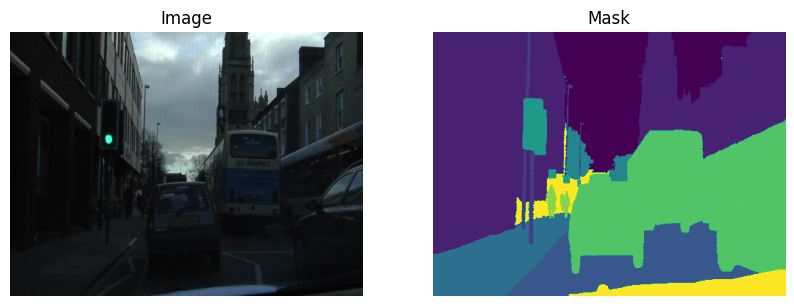

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,7), dpi=100)

ax1.imshow(train_ds[0][0])
ax1.set_title("Image")
ax1.axis(False)

ax2.imshow(train_ds[0][1])
ax2.set_title("Mask")
ax2.axis(False)

fig.show()

## Training

We advice you to use some resnet (18/50/101 -- doesn't matter) as a backbone and add upsample and decode layers on top of it. This way you could use the pretrained weights and get better segmentation with transfer learning

In this task you should:

* Add a decoder to the UNet model. The decoder should have $5$ blocks ($4$ for each res block in resnet and $1$ final block.
* Write a forward mehtod which applies resnet encoder block by block (while saving intermideate features for skip connections), and then the decoder
* Use cross entropy loss on the output of the network to train it.
* Visualize predictions on the validation set

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torchvision.models.resnet50(pretrained=True)
    # TODO add decoder blocks

  def forward(self, input):
      # TODO apply encoder by blocks, then apply decoder
      raise NotImplementedError